In [ ]:
# LIBRERIAS
import pandas as pd
from scipy.spatial.distance import cdist
import numpy as np
import random
import matplotlib.pyplot as plt
import time

In [ ]:
url = "https://tauusbmededu-my.sharepoint.com/personal/jeferson_vega231_tau_usbmed_edu_co/_layouts/15/download.aspx?share=EYAOEoa2VtVMg41GSDLMiDcB6vdDXRR5vkFyDGYIo6YbCA"

df = pd.read_csv(url)

  TSP_Instance  Num_Cities  Total_Distance  Best_Route_Category   City_1_X  \
0         a280          54    1.402741e+05                    1  73.481163   
1        att48         106    5.645695e+05                    3  16.564762   
2       att532          29    4.291223e+04                    2  50.557900   
3       bays29          41    9.111087e+04                    1  40.696244   
4     berlin52         140    1.042015e+06                    4  78.022545   

    City_1_Y   City_2_X   City_2_Y   City_3_X   City_3_Y  ...  City_145_X  \
0  10.339411  32.860837  49.195213  74.125176  22.543655  ...         NaN   
1  23.711154  35.353355  66.306605  56.742252  37.766424  ...         NaN   
2  36.820223   4.461329  88.336531  48.414394  67.342078  ...         NaN   
3  20.967084   0.115264  44.528743  82.114850  81.130896  ...         NaN   
4  60.808785  28.574624  78.129851  22.714868  32.195158  ...         NaN   

   City_145_Y  City_146_X  City_146_Y  City_147_X  City_147_Y  City_

In [ ]:
print(type(df))
print(df.head())
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
  TSP_Instance  Num_Cities  Total_Distance  Best_Route_Category   City_1_X  \
0         a280          54    1.402741e+05                    1  73.481163   
1        att48         106    5.645695e+05                    3  16.564762   
2       att532          29    4.291223e+04                    2  50.557900   
3       bays29          41    9.111087e+04                    1  40.696244   
4     berlin52         140    1.042015e+06                    4  78.022545   

    City_1_Y   City_2_X   City_2_Y   City_3_X   City_3_Y  ...  City_145_X  \
0  10.339411  32.860837  49.195213  74.125176  22.543655  ...         NaN   
1  23.711154  35.353355  66.306605  56.742252  37.766424  ...         NaN   
2  36.820223   4.461329  88.336531  48.414394  67.342078  ...         NaN   
3  20.967084   0.115264  44.528743  82.114850  81.130896  ...         NaN   
4  60.808785  28.574624  78.129851  22.714868  32.195158  ...         NaN   

   City_145_Y  City_146_X  Cit

In [ ]:
city_cols = [col for col in df.columns if col.startswith("City_")]

# Agrupar en pares de coordenadas (X, Y)
city_coords = []
for i in range(1, df['Num_Cities'][0]+1):
    x = df.iloc[0][f'City_{i}_X']
    y = df.iloc[0][f'City_{i}_Y']
    if not np.isnan(x) and not np.isnan(y):
        city_coords.append((x, y))

In [ ]:
# Convertir a matriz de distancias euclidianas
city_coords = np.array(city_coords)
distance_matrix = cdist(city_coords, city_coords)


In [ ]:
class PSO_TSP:
    def __init__(self, distance_matrix, n_particles=30, n_iterations=100, w=0.9, c1=1.0, c2=2.0):
        self.distance_matrix = distance_matrix
        self.num_cities = distance_matrix.shape[0]
        self.n_particles = n_particles
        self.n_iterations = n_iterations
        self.w = w
        self.c1 = c1
        self.c2 = c2

    def calcular_distancia(self, ruta):
        return sum(
            self.distance_matrix[ruta[i]][ruta[(i + 1) % len(ruta)]]
            for i in range(len(ruta))
        )

    def aplicar_velocidad(self, ruta, velocidad):
        nueva_ruta = ruta[:]
        for (i, j) in velocidad:
            nueva_ruta[i], nueva_ruta[j] = nueva_ruta[j], nueva_ruta[i]
        return nueva_ruta

    def calcular_velocidad(self, ruta_actual, ruta_destino):
        velocidad = []
        temp = ruta_actual[:]
        for i in range(self.num_cities):
            if temp[i] != ruta_destino[i]:
                j = temp.index(ruta_destino[i])
                velocidad.append((i, j))
                temp[i], temp[j] = temp[j], temp[i]
        return velocidad

    def two_opt(self, route):
        best = route[:]
        improved = True
        while improved:
            improved = False
            for i in range(1, self.num_cities - 2):
                for j in range(i + 1, self.num_cities):
                    if j - i == 1:
                        continue
                    new_route = best[:]
                    new_route[i:j] = best[j - 1:i - 1:-1]
                    if self.calcular_distancia(new_route) < self.calcular_distancia(best):
                        best = new_route
                        improved = True
        return best

    def run(self):
        particulas = [random.sample(range(self.num_cities), self.num_cities) for _ in range(self.n_particles)]
        velocidades = [[] for _ in range(self.n_particles)]

        mejores_rutas_personales = particulas[:]
        mejores_distancias_personales = [self.calcular_distancia(r) for r in particulas]

        mejor_idx = np.argmin(mejores_distancias_personales)
        mejor_ruta_global = mejores_rutas_personales[mejor_idx][:]
        mejor_distancia_global = mejores_distancias_personales[mejor_idx]

        for it in range(self.n_iterations):
            for i in range(self.n_particles):
                v_personal = self.calcular_velocidad(particulas[i], mejores_rutas_personales[i])
                v_global = self.calcular_velocidad(particulas[i], mejor_ruta_global)

                # Combinar velocidades con peso
                nueva_velocidad = []
                k1 = int(self.c1 * len(v_personal))
                k2 = int(self.c2 * len(v_global))
                nueva_velocidad += v_personal[:k1] + v_global[:k2]

                nueva_ruta = self.aplicar_velocidad(particulas[i], nueva_velocidad)

                # Aplicar búsqueda local
                nueva_ruta = self.two_opt(nueva_ruta)
                nueva_distancia = self.calcular_distancia(nueva_ruta)

                # Actualizar mejor personal
                if nueva_distancia < mejores_distancias_personales[i]:
                    mejores_rutas_personales[i] = nueva_ruta[:]
                    mejores_distancias_personales[i] = nueva_distancia

                # Actualizar mejor global
                if nueva_distancia < mejor_distancia_global:
                    mejor_ruta_global = nueva_ruta[:]
                    mejor_distancia_global = nueva_distancia

                particulas[i] = nueva_ruta

            print(f"Iteración {it+1}/{self.n_iterations} → Mejor distancia: {mejor_distancia_global:.4f}")

        mejor_ruta_global.append(mejor_ruta_global[0])
        return mejor_ruta_global, mejor_distancia_global


In [ ]:
import numpy as np
import random

class ACO_TSP:
    def __init__(self, distance_matrix, n_ants=20, n_iterations=100, alpha=1.0, beta=5.0, evaporation_rate=0.5, pheromone_constant=100.0):
        self.distance_matrix = distance_matrix
        self.num_cities = distance_matrix.shape[0]
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.alpha = alpha  # importancia de feromona
        self.beta = beta    # importancia de visibilidad (heurística)
        self.evaporation_rate = evaporation_rate
        self.pheromone_constant = pheromone_constant

        self.pheromones = np.ones((self.num_cities, self.num_cities))
        self.visibility = 1 / (self.distance_matrix + 1e-10)  # evitar división por cero

    def calcular_distancia(self, ruta):
        distancia = 0
        for i in range(len(ruta)):
            ciudad_actual = ruta[i]
            ciudad_siguiente = ruta[(i + 1) % len(ruta)]  # cierre del ciclo
            distancia += self.distance_matrix[ciudad_actual][ciudad_siguiente]
        return distancia

    def elegir_siguiente_ciudad(self, actual, no_visitadas):
        pheromone = self.pheromones[actual][no_visitadas]
        visibility = self.visibility[actual][no_visitadas]
        prob_numerador = (pheromone ** self.alpha) * (visibility ** self.beta)
        probabilidad = prob_numerador / np.sum(prob_numerador)
        return np.random.choice(no_visitadas, p=probabilidad)

    def construir_ruta(self):
        ruta = []
        no_visitadas = list(range(self.num_cities))
        ciudad_actual = random.choice(no_visitadas)
        ruta.append(ciudad_actual)
        no_visitadas.remove(ciudad_actual)

        while no_visitadas:
            siguiente = self.elegir_siguiente_ciudad(ciudad_actual, no_visitadas)
            ruta.append(siguiente)
            no_visitadas.remove(siguiente)
            ciudad_actual = siguiente

        return ruta

    def actualizar_feromonas(self, rutas, distancias):
        self.pheromones *= (1 - self.evaporation_rate)

        for ruta, distancia in zip(rutas, distancias):
            deposito = self.pheromone_constant / distancia
            for i in range(len(ruta)):
                a = ruta[i]
                b = ruta[(i + 1) % len(ruta)]
                self.pheromones[a][b] += deposito
                self.pheromones[b][a] += deposito  # simétrico

    def run(self):
        mejor_ruta = None
        mejor_distancia = float('inf')

        for it in range(self.n_iterations):
            rutas = [self.construir_ruta() for _ in range(self.n_ants)]
            distancias = [self.calcular_distancia(r) for r in rutas]

            # Actualizar la mejor ruta global
            min_idx = np.argmin(distancias)
            if distancias[min_idx] < mejor_distancia:
                mejor_ruta = rutas[min_idx]
                mejor_distancia = distancias[min_idx]

            # Actualizar feromonas
            self.actualizar_feromonas(rutas, distancias)

            print(f"Iteración {it}: Mejor distancia = {mejor_distancia:.6f}")

        # Cerrar ciclo (si querés retornarla cerrada)
        mejor_ruta.append(mejor_ruta[0])
        return mejor_ruta, mejor_distancia


In [ ]:
# Ejecutar ACO
start_aco = time.time()
aco = ACO_TSP(distance_matrix, n_ants=20, n_iterations=100)
aco_path, aco_distance = aco.run()
end_aco = time.time()

# Ejecutar PSO
start_pso = time.time()
pso = PSO_TSP(distance_matrix, n_particles=20, n_iterations=10)
pso_path, pso_distance = pso.run()
end_pso = time.time()

print("ACO:")
print(f"Ruta óptima: {aco_path}")
print(f"Distancia total: {aco_distance}")
print(f"Tiempo de ejecución: {end_aco - start_aco:.2f} segundos")

print("\nPSO:")
print(f"Ruta óptima: {pso_path}")
print(f"Distancia total: {pso_distance}")
print(f"Tiempo de ejecución: {end_pso - start_pso:.2f} segundos")


Iteración 0: Mejor distancia = 690.842856
Iteración 1: Mejor distancia = 674.720458
Iteración 2: Mejor distancia = 634.466967
Iteración 3: Mejor distancia = 611.134026
Iteración 4: Mejor distancia = 611.134026
Iteración 5: Mejor distancia = 611.134026
Iteración 6: Mejor distancia = 607.222965
Iteración 7: Mejor distancia = 605.896142
Iteración 8: Mejor distancia = 598.070562
Iteración 9: Mejor distancia = 598.070562
Iteración 10: Mejor distancia = 598.070562
Iteración 11: Mejor distancia = 598.070562
Iteración 12: Mejor distancia = 598.070562
Iteración 13: Mejor distancia = 598.070562
Iteración 14: Mejor distancia = 598.070562
Iteración 15: Mejor distancia = 598.070562
Iteración 16: Mejor distancia = 598.070562
Iteración 17: Mejor distancia = 591.575132
Iteración 18: Mejor distancia = 577.657345
Iteración 19: Mejor distancia = 577.657345
Iteración 20: Mejor distancia = 577.657345
Iteración 21: Mejor distancia = 577.657345
Iteración 22: Mejor distancia = 577.657345
Iteración 23: Mejor d

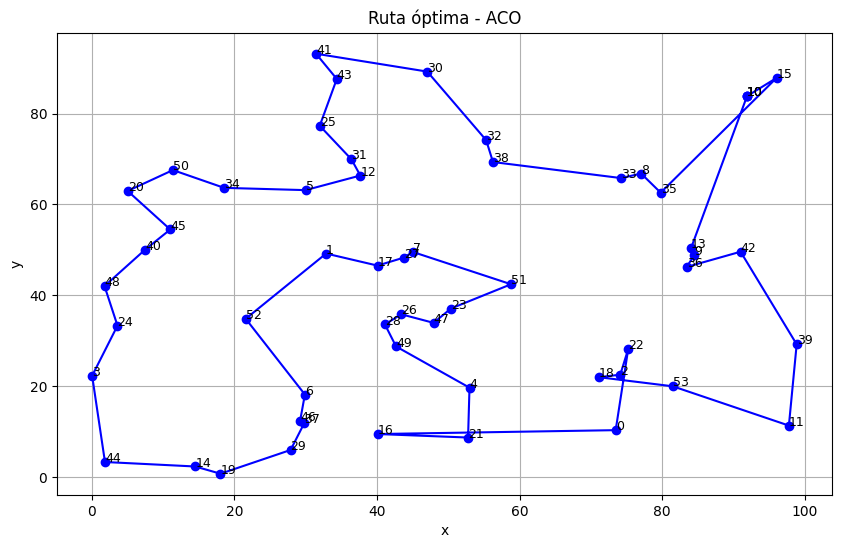

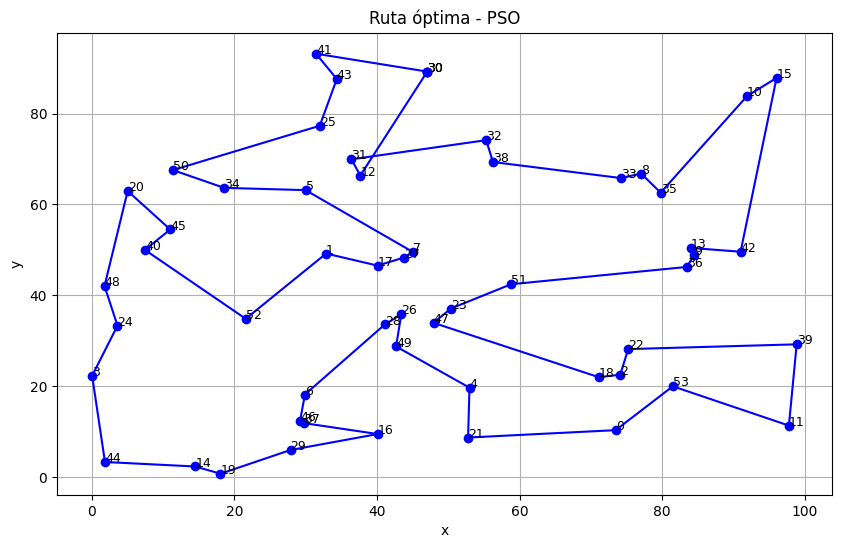

In [ ]:
def plot_route(path, coordinates, title):
    coords = coordinates[path + [path[0]]]  # Ruta + regreso al origen
    plt.figure(figsize=(10, 6))
    plt.plot(coords[:, 0], coords[:, 1], 'o-', color='blue')
    plt.title(title)
    for i, (x, y) in enumerate(coords):
        plt.text(x, y, str(path[i % len(path)]), fontsize=9)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.show()

plot_route(aco_path, city_coords, 'Ruta óptima - ACO')
plot_route(pso_path, city_coords, 'Ruta óptima - PSO')